In [188]:
#from selenium import webdriver
from bs4 import BeautifulSoup
from urllib import parse
from urllib import request
import time
import os
from io import BytesIO
import pandas as pd
from PIL import Image
import struct
import cv2
from sklearn.cluster import KMeans
clt = KMeans(n_clusters=3)

In [215]:
def saturation(color):
    return color.max() - color.min()

In [330]:
querys = pd.read_csv('datas/symbol.csv')

In [331]:
querys.values[0]

array(['MMM', '3M Company'], dtype=object)

In [384]:
brand_colors_pal = pd.DataFrame(columns=['symbol', 'color1', 'color2', 'color3'])
for query in querys.values:
    time.sleep(0.5)
    symbol = query[0]
    query = query[1]
    enc = parse.quote(query + ' brand color palette')
    url = f'https://www.google.com/search?q={enc}&tbm=isch&'
    response = requests.get(url)
    dom = BeautifulSoup(response.text, "html.parser")
    items = dom.select("img")
    for i in range(len(items)):
        try :
            link = items[i].get('src')
            response = requests.get(link).content
            a = np.fromstring(response, dtype = np.uint8)
            img = cv2.imdecode(a, cv2.IMREAD_COLOR)                             
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            break
        except:
            continue
    
    
    brandcolors = []
    for i in range(2,6):
        res = img[int((img.shape[0])/i)].reshape(-1, 3)
        clt_1 = clt.fit(res)
        colors = clt_1.cluster_centers_
        if np.array(((colors[0] == colors[1]).all(), (colors[0] == colors[2]).all(), (colors[2] == colors[1]).all())).all():
            brandcolors.append(colors[0])
        elif (colors[0] == colors[1]).all():
            brandcolors.append(colors[0])
            brandcolors.append(colors[2])
        elif (colors[0] == colors[2]).all():
            brandcolors.append(colors[0])
            brandcolors.append(colors[1])
        elif (colors[2] == colors[1]).all():
            brandcolors.append(colors[0])
            brandcolors.append(colors[1])
        else :
            brandcolors = colors
            break
    clt_1 = clt.fit(brandcolors)
    brandcolors = clt_1.cluster_centers_
    brandcolors = brandcolors.round(0)
    for i in range(3):
        if (np.array((saturation(brandcolors[i%3]),saturation(brandcolors[(i+1)%3]),saturation(brandcolors[(i+2)%3]))).max() == saturation(brandcolors[i%3])).all():

            if brandcolors[i%3].max()==brandcolors[(i+1)%3].max():
                if (brandcolors[i%3]==brandcolors[(i+1)%3]).all():
                    data_series = pd.Series([symbol, brandcolors[i%3], brandcolors[(i+2)%3], brandcolors[(i+1)%3]],index=brand_colors_pal.columns)
                else :
                    data_series = pd.Series([symbol, brandcolors[i%3], brandcolors[(i+1)%3], brandcolors[(i+2)%3]],index=brand_colors_pal.columns)

            elif brandcolors[i%3].max()==brandcolors[(i+2)%3].max():
                if (brandcolors[i%3]==brandcolors[(i+2)%3]).all():
                    data_series = pd.Series([symbol, brandcolors[i%3], brandcolors[(i+1)%3], brandcolors[(i+2)%3]],index=brand_colors_pal.columns)
                else :
                    data_series = pd.Series([symbol, brandcolors[i%3], brandcolors[(i+2)%3], brandcolors[(i+1)%3]],index=brand_colors_pal.columns)
            else :
                data_series = pd.Series([symbol, brandcolors[i%3], brandcolors[(i+2)%3], brandcolors[(i+1)%3]],index=brand_colors_pal.columns)
            
            break

    brand_colors_pal = brand_colors_pal.append(data_series, ignore_index=True)

In [396]:
a = brand_colors_pal.merge(querys,right_on='Symbol',left_on='symbol')

In [400]:
brand_colors_pal.to_csv('datas/brand_colors.csv', index=False)

In [401]:
pd.read_csv('datas/brand_colors.csv')

,symbol,color1,color2,color3
0,MMM,[161. 182. 176.],[250. 251. 253.],[228. 229. 236.]
1,ABT,[ 0. 149. 218.],[ 52. 154. 220.],[251. 253. 254.]
2,ABBV,[11. 15. 60.],[254. 254. 254.],[152. 154. 166.]
3,ABMD,[ 1. 212. 108.],[ 0. 129. 210.],[115. 61. 194.]
4,ACN,[255. 255. 255.],[154. 154. 154.],[0. 0. 0.]
...,...,...,...,...
500,YUM,[237. 29. 38.],[255. 255. 255.],[253. 220. 221.]
501,ZBRA,[ 10. 140. 120.],[ 90. 194. 177.],[249. 248. 245.]
502,ZBH,[ -0. 159. 223.],[55. 27. 0.],[51. 51. 51.]
503,ZION,[84. 83. 74.],[218. 218. 217.],[255. 255. 255.]


In [402]:
a[a['symbol'] == 'AAPL']

,symbol,color1,color2,color3,Symbol,Name
45,AAPL,"[162.0, 171.0, 173.0]","[228.0, 230.0, 231.0]","[255.0, 255.0, 255.0]",AAPL,Apple Inc.


In [381]:
brandcolors[i%3]==brandcolors[(i+1)%3]

array([ True,  True,  True])

In [379]:
brandcolors

array([[  0., 154.,  73.],
       [  0., 154.,  73.],
       [  0., 154.,  73.]])

In [353]:
for i in range(3):
    if (np.array((saturation(brandcolors[i%3]),saturation(brandcolors[(i+1)%3]),saturation(brandcolors[(i+2)%3]))).max() == (brandcolors[i%3])).all():
        print(i)

    


In [359]:
i = 2

In [360]:
(np.array((saturation(brandcolors[i%3]),saturation(brandcolors[(i+1)%3]),saturation(brandcolors[(i+2)%3]))).max() == saturation(brandcolors[i%3])).all()

False

In [361]:
np.array((saturation(brandcolors[i%3]),saturation(brandcolors[(i+1)%3]),saturation(brandcolors[(i+2)%3]))).max()

20.666666666666657

In [363]:
saturation(brandcolors[i%3])

7.638297872340445

In [349]:
(saturation(brandcolors[0]),saturation(brandcolors[1]),saturation(brandcolors[2]))

(20.666666666666657, 3.016949152542395, 7.638297872340445)

In [343]:
np.array((saturation(brandcolors[i%3]),saturation(brandcolors[(i+1)%3]),saturation(brandcolors[(i+2)%3]))).max() == (brandcolors[i%3])

array([False, False, False])

In [334]:
brandcolors

KMeans(n_clusters=3)

In [160]:
#query = query[0]
query = 'facebook.'
enc = parse.quote(query + 'color palette')
url = f'https://www.google.com/search?q={enc}&tbm=isch&'
response = requests.get(url)
#images = driver.find_elements_by_tag_name("img")

In [161]:
dom = BeautifulSoup(response.text, "html.parser")
items = dom.select("img")
items[2]

<img alt="" class="t0fcAb" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRA4lAyyrGpEC5wJtJE-A95xps_OYhnaUT5zl1WTFv-fLz7fycY9d0x1LHtKT4&amp;s"/>

In [162]:
items[2].get('src')

'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRA4lAyyrGpEC5wJtJE-A95xps_OYhnaUT5zl1WTFv-fLz7fycY9d0x1LHtKT4&s'

In [163]:
response = requests.get(items[1].get('src')).content

In [164]:
response

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x8c\x00\x00\x00\x8c\x08\x03\x00\x00\x00\x99\x1e\xb1\x0c\x00\x00\x00\x9fPLTE\xea\xea\xea\xff\xff\xff\xf6\xf7\xf8X\x90\xffBg\xb2\x18w\xf2Jw\xd2L\x87\xf3\x0bs\xf2\xca\xd4\xea\xef\xef\xef?e\xb1Af\xaf\x14p\xe6\xf4\xf4\xf5\xef\xee\xeaWu\xb7\x96\xb1\xf1P\x8c\xff\x8e\x9d\xc48a\xb0\xdc\xdf\xe4\x87\xa8\xeb\xd3\xd3\xd4\x00l\xf3\xcc\xcc\xcd\xc1\xc1\xc3\xde\xde\xdf\x00o\xf2\xe4\xe4\xe4\xb3\xc6\xedN\x8c\xf1*}\xf2\xf4\xf1\xe7\x7f\xa3\xef\x9c\xb8\xef\xc2\xd0\xec\xaa\xb4\xcf\x91\xa5\xd8\xd4\xda\xe7\xb7\xc0\xd5@r\xd2B\x83\xf5\x00j\xe6(X\xad\xb4\xb4\xb6f\x9b\xf6\x00g\xf1\xd8\xe4\xfc\xe5\xed\xfd\xf2\xf5\xfe\xa7\xbf\xedq\x88\xbe\xaeE!)\x00\x00\x02\nIDATx\x9c\xed\xd9\rS\x9b0\x1c\xc7\xf1\xa4[F\xca\x9c\x11\'K \xa4\x14\xea\xc3\x1e\xc4:\xdd\xfb\x7fm\xfb\x03\xa7\xe3\x96X\xeb\xa9\x176\x7f\x1f8\xac)\xa6_9\xe8q\x07c\x00\x00\x00\xf0v\xa8A\xec\x8a\x81R\xab\xb6\xae\xdb\xd5\x1crT\x9eTRJc\x92<z\x8d\xca\xd7R\x88J\\\xd5r\x1d\xbd\xa6\xa9\xfb\x96\x8c\xf3\x9buU7q[\xd4\xb2\x12

In [165]:
import cv2

In [166]:
a = np.fromstring(response, dtype = np.uint8)

In [167]:
img = cv2.imdecode(a, cv2.IMREAD_COLOR)                             
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [277]:
img.shape

(140, 140, 3)

In [180]:
img[int((img.shape[0])/2)]

array([[234, 234, 234],
       [234, 234, 234],
       [234, 234, 234],
       [234, 234, 234],
       [234, 234, 234],
       [234, 234, 234],
       [234, 234, 234],
       [234, 234, 234],
       [234, 234, 234],
       [234, 234, 234],
       [234, 234, 234],
       [234, 234, 234],
       [234, 234, 234],
       [220, 223, 228],
       [ 87, 117, 183],
       [ 63, 101, 177],
       [ 66, 103, 178],
       [ 66, 103, 178],
       [ 66, 103, 178],
       [ 66, 103, 178],
       [ 66, 103, 178],
       [ 66, 103, 178],
       [ 66, 103, 178],
       [ 66, 103, 178],
       [ 66, 103, 178],
       [ 66, 103, 178],
       [ 66, 103, 178],
       [ 66, 103, 178],
       [ 66, 103, 178],
       [ 66, 103, 178],
       [ 66, 103, 178],
       [ 66, 103, 178],
       [ 66, 103, 178],
       [ 66, 103, 178],
       [ 66, 103, 178],
       [ 65, 102, 175],
       [ 74, 119, 210],
       [ 88, 144, 255],
       [ 88, 144, 255],
       [ 88, 144, 255],
       [ 88, 144, 255],
       [ 88, 144

In [319]:
frame = pd.DataFrame(columns=['symbol', 'color1', 'color2', 'color3'])

In [329]:
frame.append(pd.Series(['symbol', colors[0], colors[1],colors[2]], index=frame.columns), ignore_index=True)

,symbol,color1,color2,color3
0,symbol,"[234.0, 234.0, 234.0]","[234.0, 234.0, 234.0]","[234.0, 234.0, 234.0]"


In [296]:
brandcolors.add(np.array([1,2,3]))

TypeError: unhashable type: 'numpy.ndarray'

In [315]:
clt_1 = clt.fit(colors)

In [316]:
colors = clt_1.cluster_centers_

In [317]:
colors

array([[234., 234., 234.],
       [234., 234., 234.],
       [234., 234., 234.]])

In [285]:
(colors[0] == colors[1]).all()

True

In [281]:
img[0].cluster_centers_

AttributeError: 'numpy.ndarray' object has no attribute 'cluster_centers_'

In [282]:
res = img[0].reshape(-1, 3)
clt_1 = clt.fit(res)
colors = clt_1.cluster_centers_

In [284]:
color1, color2, color3 = colors[0], colors[1], colors[2]

In [ ]:
colors.max()

In [221]:
saturation(colors[0])

0.0

In [222]:
colors

array([[234., 234., 234.],
       [234., 234., 234.],
       [234., 234., 234.]])

In [210]:
colors[2].max() - colors[2].min()

112.34782608695654

In [200]:
def palette(clusters):
    width=300
    palette = np.zeros((50, width, 3), np.uint8)
    steps = width/clusters.cluster_centers_.shape[0]
    for idx, centers in enumerate(clusters.cluster_centers_): 
        palette[:, int(idx*steps):(int((idx+1)*steps)), :] = centers
    return palette

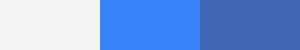

In [203]:
Image.fromarray(palette(clt_1).astype('u1'))

In [189]:
import struct
network_stream = struct.pack('>I', response)
(converted_int,) = struct.unpack_from('>I', network_stream, 0) 


error: required argument is not an integer

In [ ]:
requests.get(url).content

In [47]:
dom = BeautifulSoup(response.text, "html.parser")

In [49]:
imgUrl = dom.find("img")["src"]

In [50]:
imgUrl

'/images/branding/searchlogo/1x/googlelogo_desk_heirloom_color_150x55dp.gif'

In [26]:
response

<Response [200]>